数据和安装包

In [ ]:
!pip install git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

In [ ]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

import pandas as pd
import seaborn as sns
#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

In [34]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

#All these packages need to be installed from pip
#For ML
import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

数据到df

In [2]:
covid_df = pd.read_csv("/Users/raychanan/Github/ray_content_final_project/ray_content_final_project/Corona_NLP_train_utf8.csv", header=0)

covid_df.dropna(inplace=True) # dropna
# now_df.drop("Unnamed: 0", axis=1, inplace=True) # drop column
covid_df.rename(columns={'OriginalTweet':'text', "Sentiment":'sentiment'}, inplace=True) #renmae column

covid_df

,UserName,ScreenName,Location,TweetAt,text,sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
5,3804,48756,"ÃœT: 36.319708,-82.363649",16-03-2020,As news of the regionÂ’s first confirmed COVID...,Positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,Positive
...,...,...,...,...,...,...
41147,44946,89898,"Brooklyn, NY",14-04-2020,YÂ’all really shitting that much more at home?...,Negative
41149,44948,89900,"Toronto, Ontario",14-04-2020,Still shocked by the number of #Toronto superm...,Negative
41150,44949,89901,OHIO,14-04-2020,I never that weÂ’d be in a situation &amp; wor...,Positive
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral


In [5]:
covid_df['sentiment'].unique()

array(['Neutral', 'Positive', 'Negative', 'Extremely Positive',
       'Extremely Negative'], dtype=object)

In [7]:
covid_df = covid_df.sample(n=5000, random_state=123)

Tokenize and normalize

In [8]:
covid_df['tokenized_text'] = covid_df['text'].apply(lambda x: lucem_illud.word_tokenize(x))
covid_df['normalized_text'] = covid_df['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

It's a DataFrame! and it looks like this:

In [9]:
covid_df.head()

,UserName,ScreenName,Location,TweetAt,text,sentiment,tokenized_text,normalized_text
8048,11847,56799,"Bandera, Texas",19-03-2020,Gas prices dropping to record lows with NO pla...,Negative,"[Gas, prices, dropping, to, record, lows, with...","[gas, price, drop, record, low, place, covid19..."
23223,27022,71974,Uganda,25-03-2020,ON SALE:\r\r\n\r\r\nFACE MASKS 3PLY AND N95\r\...,Extremely Positive,"[ON, SALE, FACE, MASKS, 3PLY, AND, N95, RAPID,...","[sale, face, mask, 3ply, n95, rapid, covid-19,..."
19704,23503,68455,"Salt Lake City, Utah",24-03-2020,The impact of COVID-19 is reaching all the way...,Positive,"[The, impact, of, COVID-19, is, reaching, all,...","[impact, covid-19, reach, way, gas, tank, pric..."
17988,21787,66739,Boston. MA,23-03-2020,3x as many consumers are worried about dying f...,Negative,"[3x, as, many, consumers, are, worried, about,...","[3x, consumer, worry, dye, covid-19, lose, job..."
14393,18192,63144,"England, United Kingdom",21-03-2020,How much #toiletpaper is enough? #coronavirus ...,Neutral,"[How, much, toiletpaper, is, enough, coronavir...","[toiletpaper, coronavirus, https://t.co/lqszyf..."


Neat! Let's turn the 'sentiment' column into a binary category variable.

In [10]:
covid_df['category'] = [s == 'Neutral' for s in covid_df['sentiment']]

Tokenize and normalize

In [11]:
covid_df['tokenized_text'] = covid_df['text'].apply(lambda x: lucem_illud.word_tokenize(x))
covid_df['normalized_text'] = covid_df['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

Let's split the data into training data and testing data.

In [12]:
holdBackFraction = .2
train_data_df, test_data_df = lucem_illud.trainTestSplit(covid_df, holdBackFraction=holdBackFraction)

In [13]:
print(len(train_data_df))
print(len(test_data_df))

4000
1000


## Logistic Regression

First, let's try with a logistic regression, which may be familiar to you from statistical methods classes. First, we must turn the training dataset into a tf-idf matrix

In [14]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

In [15]:
TFVects.shape

(4000, 5399)

We can save this in the dataframe to make things easier

In [16]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

在回归中，我们的变量不能多于案例。所以，我们需要先做减维。首先，我们将用PCA来实现。这里我关注分类，所以所有的主成分都会被计算出来

In [17]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

We can store the PCA space vectors in the dataframe too:

In [18]:
train_data_df['pca'] = [r for r in reduced_data]

Visualization in 2D:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


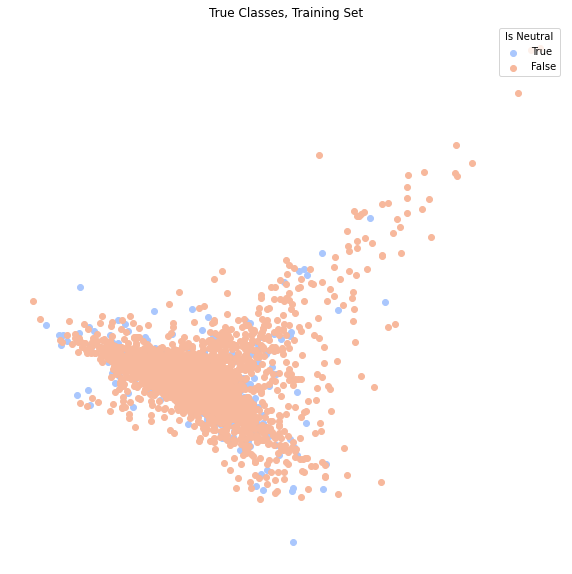

In [19]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Neutral
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Neutral
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is Neutral')
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish "Neutral" very well. Let's perform a screeplot to see how many Principal Components we need.

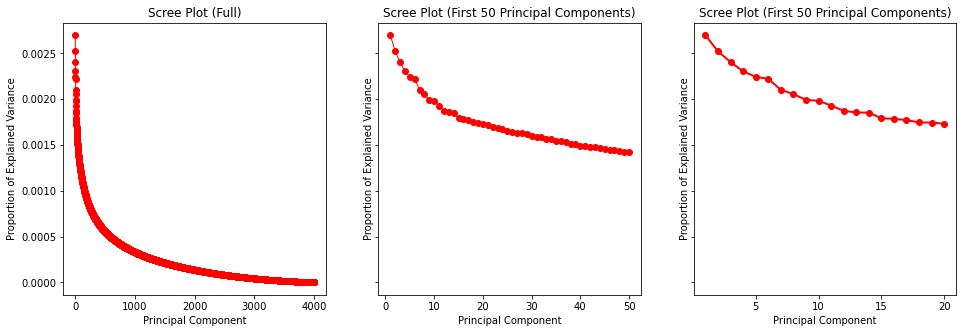

In [20]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [21]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

Now we fit a logistic regression to our data.

In [22]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

LogisticRegression()

让我们看看逻辑回归在我们开发模型的训练数据集上的表现。结果还错:80%

In [23]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.8

How does it perform on the testing dataset, which we "held out" and did not use for model training? We need to repeat all the steps on the testing data, but without retraining:

In [24]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.819

Even better! How about using more dimensions (40)?

In [25]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Training:
0.80025
Testing:
0.821


Or still more (100)?

In [26]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Training:
0.80125
Testing:
0.82


Or even more (200)!

In [27]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

Training:
0.80225
Testing:
0.819


This is becoming ridiculous (400)!

In [28]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Training:
0.806
Testing:
0.82


很明显,增加维度并没有带来更大幅度的提升

增加协变量的数量会使我们的数据过度拟合，看来使用逻辑回归，我们的预测准确率有81%左右。不过，我们还可以尝试使用每个词的TF-IDF分数进行逻辑回归，但要采用L1正则化或L1-norm损失函数，也就是最小绝对偏差（LAD）、最小绝对误差（LAE）或L1惩罚。它将目标值( 𝑌𝑖 )和估计值( 𝑓(𝑥𝑖))之间的绝对差值(S)最小化，并修剪所有不重要的变量(即单词TF-IDF分数)。

The result is a model retaining only the most individually significant features.

In [29]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.81025


Train the model using training data, and then test it on the testing data.

In [30]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

0.818


81% accuracy seems like the best we can get by using a logistic regression.

Now let's try with Naive Bayes. Classically, it is trained with word counts, but TF-IDF vectors are also quite good:

In [35]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

BernoulliNB()

In [36]:
print("Training:")
print(naiveBayes.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))
print("Testing:")
print(naiveBayes.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Training:
0.88125
Testing:
0.796


甚至比logit还差一些。那其他措施呢？我们先把预测结果保存在数据框架中，以节省每次重新运行模型的时间。

In [37]:
test_data_df['nb_predict'] = naiveBayes.predict(np.stack(test_data_df['vect'], axis=0))
test_data_df['nb_predict_prob_true'] = naiveBayes.predict_proba(np.stack(test_data_df['vect'], axis=0))[:,0] #other is prop false

Precision:

In [38]:
sklearn.metrics.precision_score(test_data_df['category'], test_data_df['nb_predict'])

0.21951219512195122

Recall:

In [39]:
sklearn.metrics.recall_score(test_data_df['category'], test_data_df['nb_predict'])

0.049723756906077346

F1-measure:

In [40]:
sklearn.metrics.f1_score(test_data_df['category'], test_data_df['nb_predict'])

0.08108108108108107

Let's take a look at how well our posterior distribution looks relative to the truth.

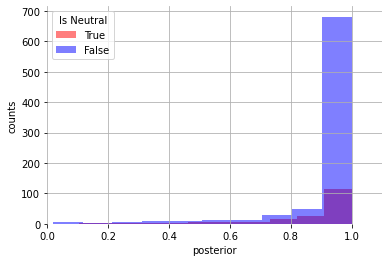

In [41]:
fig, ax = plt.subplots()
ax.grid(False)
ax.set_frame_on(False)
test_data_df[test_data_df['category'].eq(True)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'True', color = 'red')
test_data_df[test_data_df['category'].eq(False)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'False', color = 'blue')
ax.set_xlim((0,1.1))
ax.legend(title = "Is Neutral")
ax.set_xlabel('posterior')
ax.set_ylabel('counts')
plt.show()

这个分类出人意料地准确。我们甚至可以用一些简单的数学来看看哪些词最有影响力

In [44]:
#Top indices
trueVals, falseVals = naiveBayes.feature_log_prob_

words_dict = {
    'Neutral' : [],
    'Neutral_log_prob' : [],
    'Clinton' : [],
    'Clinton_log_prob' : [],
}

for i, prob in sorted(enumerate(trueVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Neutral'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Neutral_log_prob'].append(prob)

for i, prob in sorted(enumerate(falseVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Clinton'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Clinton_log_prob'].append(prob)
    
pandas.DataFrame(words_dict)

,Neutral,Neutral_log_prob,Clinton,Clinton_log_prob
0,day,-3.594194,socialdistancing,-3.221373
1,stop,-3.594194,quarantine,-3.509055
2,virus,-3.617184,impact,-3.551614
3,price,-3.628880,behavior,-3.642586
4,safe,-3.628880,market,-3.642586
5,shop,-3.640714,corona,-3.691376
6,health,-3.652690,customers,-3.691376
7,think,-3.677082,march,-3.742670
8,customers,-3.702083,2020,-3.796737
9,free,-3.702083,health,-3.796737


## Multinomial Naive Bayes

What if we want to classify our text into one of *many* classes? The multinomial Naive Bayes generating model assumes that document features (e.g., words) are generated by draws from a multinomial distribution (recall this gives the probability to observe a particular pattern of counts across features). 
如果我们想把我们的文本分为许多类中的一类呢？多项式奈夫贝叶斯生成模型假设文档特征（如单词）是通过从多项式分布中抽签生成的（记得这给出了在各个特征中观察到特定计数模式的概率）。

Let's use again the dataset we used in week 3, the 20 newsgroup dataset.

In [46]:
covid_df['category'] = covid_df['sentiment']
covid_df.head()

,UserName,ScreenName,Location,TweetAt,text,sentiment,tokenized_text,normalized_text,category
8048,11847,56799,"Bandera, Texas",19-03-2020,Gas prices dropping to record lows with NO pla...,Negative,"[Gas, prices, dropping, to, record, lows, with...","[gas, price, drop, record, low, place, covid19...",Negative
23223,27022,71974,Uganda,25-03-2020,ON SALE:\r\r\n\r\r\nFACE MASKS 3PLY AND N95\r\...,Extremely Positive,"[ON, SALE, FACE, MASKS, 3PLY, AND, N95, RAPID,...","[sale, face, mask, 3ply, n95, rapid, covid-19,...",Extremely Positive
19704,23503,68455,"Salt Lake City, Utah",24-03-2020,The impact of COVID-19 is reaching all the way...,Positive,"[The, impact, of, COVID-19, is, reaching, all,...","[impact, covid-19, reach, way, gas, tank, pric...",Positive
17988,21787,66739,Boston. MA,23-03-2020,3x as many consumers are worried about dying f...,Negative,"[3x, as, many, consumers, are, worried, about,...","[3x, consumer, worry, dye, covid-19, lose, job...",Negative
14393,18192,63144,"England, United Kingdom",21-03-2020,How much #toiletpaper is enough? #coronavirus ...,Neutral,"[How, much, toiletpaper, is, enough, coronavir...","[toiletpaper, coronavirus, https://t.co/lqszyf...",Neutral


We can pick specific categories, and pull the relevant training and testing sets. 

Now we need to tokenize, and make a training and testing set:

In [48]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud.trainTestSplit(covid_df, holdBackFraction=holdBackFraction)

In [49]:
print(len(train_ng_df))
print(len(test_ng_df))

4000
1000


We need to extract features from the text. We can use built-in feature extraction to do so. We will use a tf-idf vectorizer, which converts the document into a vector of words with tf-idf weights (term-frequency inverse-document frequency). This gives high weight to words that show up a lot in a given document, but rarely across documents in the corpus (more distinctive). 

我们需要从文本中提取特征。我们可以使用内置的特征提取来实现。我们将使用tf-idf向量器，它将文档转换为具有tf-idf权重（term-frequency逆文档频率）的单词向量。这就给那些在某个文档中出现次数多，但在语料库中各文档中很少出现的词以高权重（比较有特色）。

In [50]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

Now we can train the model:

In [51]:
MultinomialNB_ng = sklearn.naive_bayes.MultinomialNB()
MultinomialNB_ng.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

MultinomialNB()

...and save predictions to the dataframe:

In [52]:
train_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(train_ng_df['vect'], axis=0))
print("Training score:")
print(MultinomialNB_ng.score(np.stack(train_ng_df['vect'], axis=0), train_ng_df['category']))

Training score:
0.701


In [53]:
train_ng_df[['category', 'nb_predict']][:10]

,category,nb_predict
3434,Neutral,Neutral
19824,Negative,Negative
22143,Positive,Positive
18471,Negative,Neutral
10266,Extremely Positive,Positive
40351,Negative,Negative
7188,Extremely Negative,Positive
6546,Extremely Positive,Positive
4154,Extremely Negative,Positive
37690,Extremely Positive,Extremely Positive


Looks pretty good, lets examine the testing dataset:

In [54]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(MultinomialNB_ng.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.323


很遗憾,效果很差

We can even use a confusion matrix

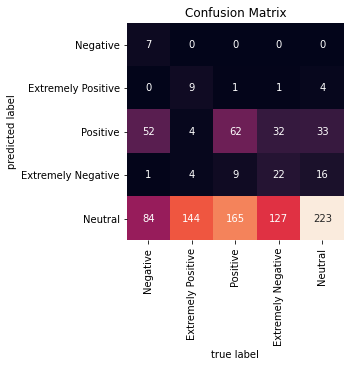

In [55]:
lucem_illud.plotConfusionMatrix(MultinomialNB_ng, test_ng_df)

Let's calculate the precision, recall, and F-measures.

In [57]:
print(sklearn.metrics.precision_score(test_ng_df['category'], test_ng_df['nb_predict'], average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test_ng_df['category'], test_ng_df['nb_predict'], average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test_ng_df['category'], test_ng_df['nb_predict'], average = 'weighted')) #F-1 measure

0.4807322286697703
0.323
0.2548113383454585


We can evaluate these per catagory. This has the same requiments as `plotConfusionMatrix`:

In [58]:
lucem_illud.metrics.evaluateClassifier(MultinomialNB_ng, test_ng_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Extremely Positive,0.158,0.524375,0.600000,0.185540,0.055901
Extremely Negative,0.137,0.524306,1.000000,0.185611,0.048611
Neutral,0.190,0.542102,0.423077,0.211141,0.120879
Positive,0.573,0.544869,0.300135,0.295500,0.807971
Negative,0.296,0.551509,0.338798,0.263631,0.261603


这个结果很有意思, 很显然,这个模型对极端情绪和中立情绪的分类非常准确

We can also plot the ROC curves. This has the same requiments as `plotConfusionMatrix`:

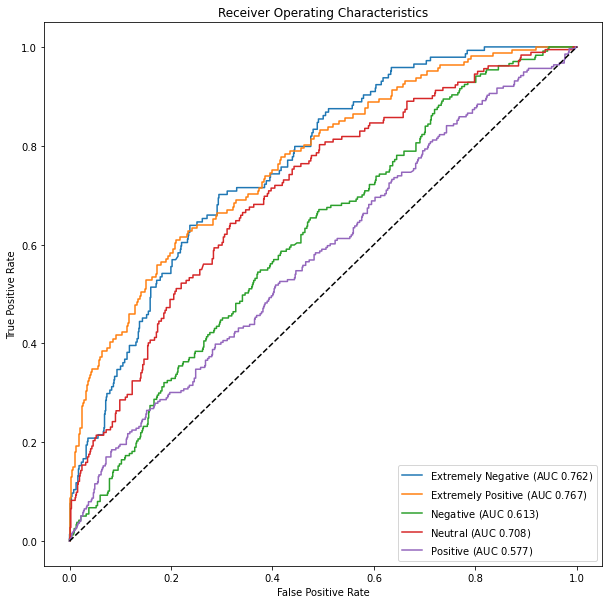

In [59]:
lucem_illud.plotMultiROC(MultinomialNB_ng, test_ng_df)

And we can plot the PCA space visualization:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

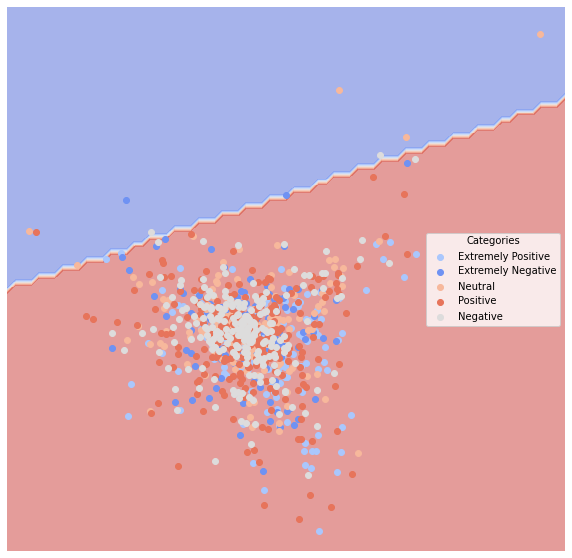

In [60]:
lucem_illud.plotregions(MultinomialNB_ng, test_ng_df)

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, perform Logistic and Naïve Bayes classification (binary or multinomial) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.


决策树方法

决策树可用于预测分类/分类标签(即，分类)和连续标签(即，回归)。

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

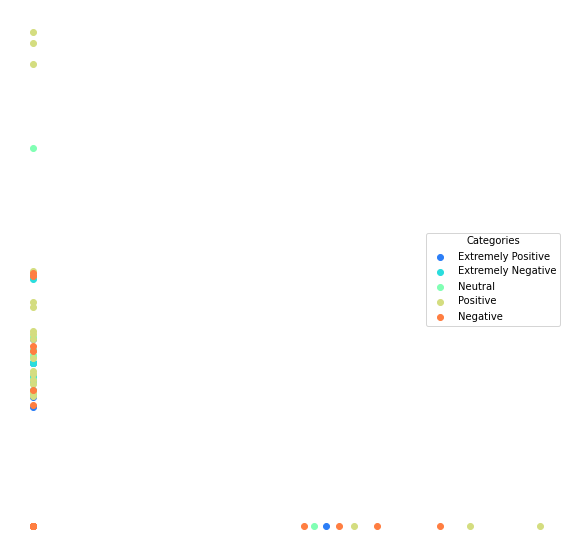

In [71]:

lucem_illud.plotter(train_ng_df)

现在我们从sklearn.tree（熟悉的语法）导入我们的决策树分类器，并使用拟合方法对其进行拟合。

In [72]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(train_ng_df['vect'], axis =0), df_exampleTree_train['category'])

DecisionTreeClassifier(max_depth=4, random_state=0)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

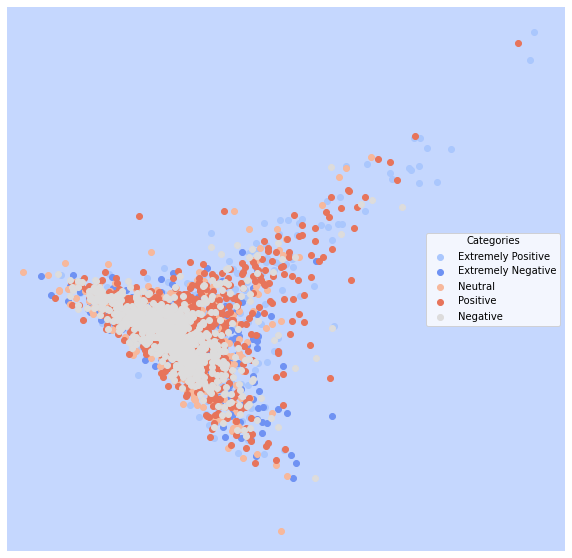

In [74]:
lucem_illud.plotregions(clf_tree, train_ng_df)

In [75]:
lucem_illud.evaluateClassifier(clf_tree, test_ng_df)

/Users/raychanan/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raychanan/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Extremely Positive,0.163,0.498808,0.00000,0.161000,0.000000
Extremely Negative,0.144,0.500000,0.00000,0.144000,0.000000
Neutral,0.182,0.500000,0.00000,0.182000,0.000000
Positive,0.720,0.501641,0.27666,0.276658,0.996377
Negative,0.239,0.500144,0.25000,0.237055,0.004219


In [ ]:
跟之前的结果是一致的:极端情绪好和中立情绪分类水平好